In [1]:
from IPython.display import display, Markdown

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
from sklearn.datasets import fetch_openml
iris = fetch_openml('diabetes')
iris.data.shape, iris.target.shape

/home/hfcp/anaconda3/lib/python3.8/site-packages/sklearn/datasets/_openml.py:404: UserWarning: Multiple active versions of the dataset matching the name diabetes exist. Versions may be fundamentally different, returning version 1.
  warn("Multiple active versions of the dataset matching the name"


((768, 8), (768,))

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(iris.data, iris.target, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [7]:
scaler = MinMaxScaler().fit(train_X)
scaled_train_X = scaler.transform(train_X)

label_dict = {v:k for k,v in enumerate(train_y.unique())}

train_y = train_y.map(label_dict.get).values
test_y = test_y.map(label_dict.get).values

Model name RandomForestClassifier is on process
Validation Accuracy :   0.7552083333333334
ECE : 0.1349049564270152


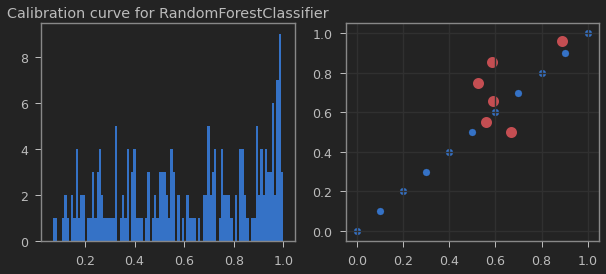

_____________

Model name GaussianNB is on process
Validation Accuracy :   0.734375
ECE : 0.22262235482967113


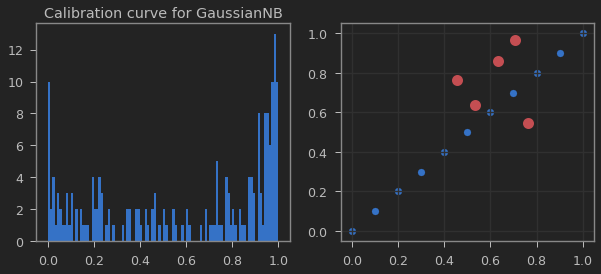

_____________

Model name SVC is on process
Validation Accuracy :   0.7447916666666666
ECE : 0.14405750996213135


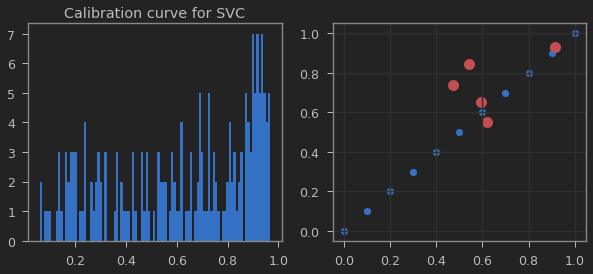

_____________

Model name LogisticRegression is on process
Validation Accuracy :   0.7291666666666666
ECE : 0.09657959836801669


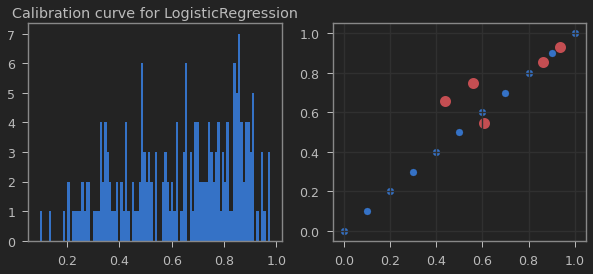

_____________

In [8]:
orgin_score_ls = list()
orgin_acc_ls = list()

for model_obj in [RandomForestClassifier, GaussianNB, SVC, LogisticRegression] :     
    model_name = str(model_obj).split(".")[-1].replace("'>",'')
    print("Model name {} is on process".format(model_name))
    
    if model_name == 'SVC' :
        model = model_obj(probability=True).fit(X=scaled_train_X, y=train_y.to_numpy())
    else :
        model = model_obj().fit(X=scaled_train_X, y=train_y.to_numpy())

    predicted_prob = model.predict_proba(scaler.transform(test_X))

    acc = (predicted_prob.argmax(1) == test_y.to_numpy()).sum() / test_y.shape[0]
    orgin_acc_ls.append(acc)
    print("Validation Accuracy :  ", acc)

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].set_title("Distribution of predicted probability for {}".format(model_name))
    ax[0].hist(predicted_prob[:,1], bins=100)    

    scores = calibration_curve(test_y, predicted_prob.max(1), n_bins=10)
    ece = np.mean(np.abs(scores[0] - scores[1]))
    orgin_score_ls.append(ece)
    print("ECE : {}".format(ece))
    
    ax[0].set_title("Calibration curve for {}".format(model_name))
    ax[1].scatter(np.arange(10+1)*0.1, np.arange(10+1)*0.1, )
    ax[1].scatter(*scores, linewidth=4, c='r')
    ax[1].grid()
    plt.show()
    
    display(Markdown("_____________"))

Model name RandomForestClassifier is on process
Validation Accuracy :   0.7291666666666666
ECE : 0.11618054163367804


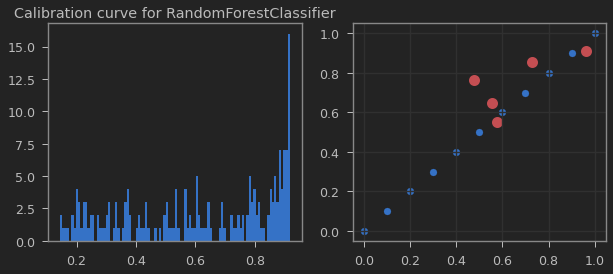

_____________

Model name GaussianNB is on process
Validation Accuracy :   0.75
ECE : 0.1871975230711834


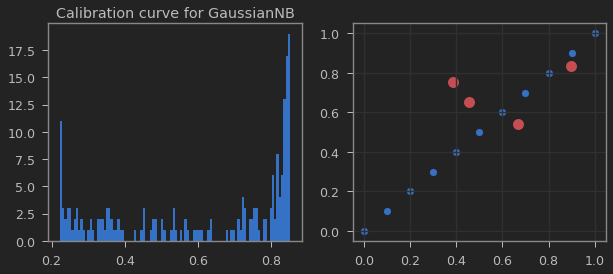

_____________

Model name SVC is on process
Validation Accuracy :   0.7447916666666666
ECE : 0.14112668888867272


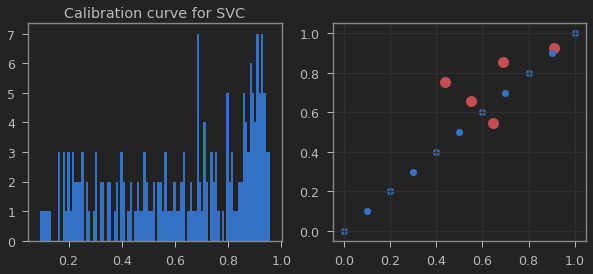

_____________

Model name LogisticRegression is on process
Validation Accuracy :   0.7239583333333334
ECE : 0.1468112949569446


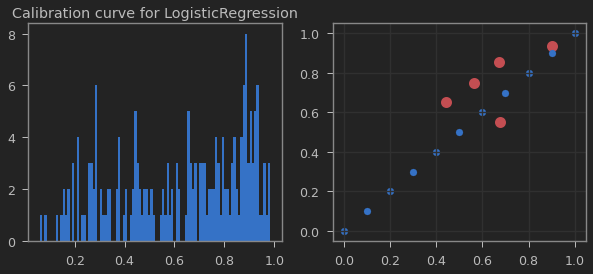

_____________

In [9]:
calibrated_score_ls = list()
calibrated_acc_ls = list()

for model_obj in [RandomForestClassifier, GaussianNB, SVC, LogisticRegression] :     
    model_name = str(model_obj).split(".")[-1].replace("'>",'')
    print("Model name {} is on process".format(model_name))
    
    if model_name == 'SVC' :
        model = model_obj(probability=True)
    else :
        model = model_obj()
        
    calibrated_clf = CalibratedClassifierCV(base_estimator=model, cv=10)
    calibrated_clf.fit(X=scaled_train_X, y=train_y.to_numpy())
    predicted_prob = calibrated_clf.predict_proba(scaler.transform(test_X))

    acc = (predicted_prob.argmax(1) == test_y.to_numpy()).sum() / test_y.shape[0]
    calibrated_acc_ls.append(acc)
    print("Validation Accuracy :  ", acc)

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].set_title("Distribution of predicted probability for {}".format(model_name))
    ax[0].hist(predicted_prob[:,1], bins=100)    

    scores = calibration_curve(test_y, predicted_prob.max(1), n_bins=10)
    ece = np.mean(np.abs(scores[0] - scores[1]))
    calibrated_score_ls.append(ece)
    print("ECE : {}".format(ece))
    
    ax[0].set_title("Calibration curve for {}".format(model_name))
    ax[1].scatter(*scores, linewidth=4, c='r')
    
    ax[1].scatter(np.arange(10+1)*0.1, np.arange(10+1)*0.1, )
    ax[1].grid()
    plt.show()
    
    display(Markdown("_____________"))

In [10]:
model_nm_list = [str(model_obj).split(".")[-1].replace("'>",'') \
                 for model_obj in [RandomForestClassifier, GaussianNB, SVC, LogisticRegression]]

[]

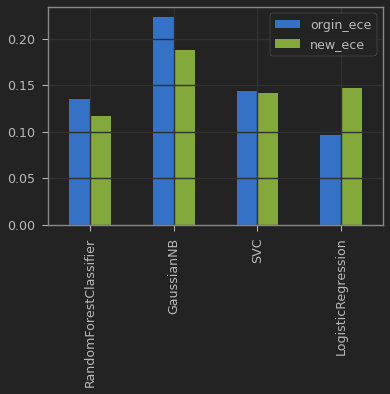

In [11]:
score_df = pd.DataFrame(columns=['orgin_ece', 'new_ece'], index=model_nm_list)
score_df['orgin_ece'] = orgin_score_ls
score_df['new_ece'] = calibrated_score_ls
ax = score_df.plot.bar(grid=True)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

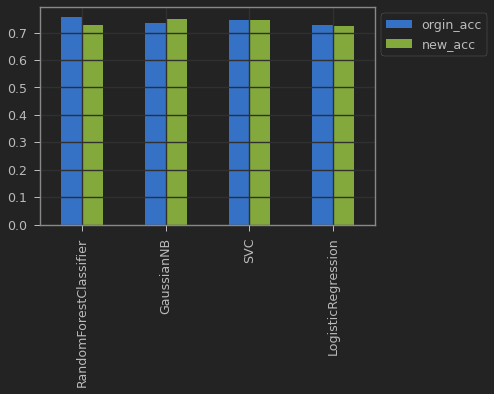

In [12]:
score_df = pd.DataFrame(columns=['orgin_acc', 'new_acc'], index=model_nm_list)
score_df['orgin_acc'] = orgin_acc_ls
score_df['new_acc'] = calibrated_acc_ls
ax = score_df.plot.bar(grid=True)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()